# CNN方法

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from tqdm.keras import TqdmCallback
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
import itertools


In [2]:
#====================================================
#            Data preprocessing(icubworld28)
#====================================================
def normalize_data(x):
    mean = np.mean(x, axis=(0,1,2))
    std = np.std(x, axis=(0,1,2))
    return (x - mean) / std



def load_icubworld28_dataset_with_val(root_dir, target_size=(32, 32), val_ratio=0.1):
    X_train_all, y_train_all = [], []
    X_test, y_test = [], []

    # 类别索引
    class_names = sorted([d.name for d in Path(root_dir, "train").iterdir() if d.is_dir()])
    class_to_index = {cls_name: idx for idx, cls_name in enumerate(class_names)}
    print(f"Classes: {class_to_index}")

    # 加载 train 数据
    for class_name in class_names:
        class_path = Path(root_dir, "train", class_name)
        for subfolder in class_path.iterdir():
            if not subfolder.is_dir():
                continue
            for img_file in subfolder.glob("*.ppm"):
                try:
                    img = load_img(img_file, target_size=target_size)
                    img_array = img_to_array(img)
                    X_train_all.append(img_array)
                    y_train_all.append(class_to_index[class_name])
                except Exception as e:
                    print(f"[Train] 读取失败: {img_file} -> {e}")

    # 加载 test 数据
    for class_name in class_names:
        class_path = Path(root_dir, "test", class_name)
        for subfolder in class_path.iterdir():
            if not subfolder.is_dir():
                continue
            for img_file in subfolder.glob("*.ppm"):
                try:
                    img = load_img(img_file, target_size=target_size)
                    img_array = img_to_array(img)
                    X_test.append(img_array)
                    y_test.append(class_to_index[class_name])
                except Exception as e:
                    print(f"[Test] 读取失败: {img_file} -> {e}")

    # 划分 train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_all, y_train_all, test_size=val_ratio, stratify=y_train_all, random_state=42)

    return (np.array(X_train), np.array(y_train),
            np.array(X_val), np.array(y_val),
            np.array(X_test), np.array(y_test),
            class_names)

In [3]:
data_dir = "dataset/iCubWorld28"  # 修改为你的实际路径

X_train, y_train, X_val, y_val, X_test, y_test, class_names = load_icubworld28_dataset_with_val(data_dir)

print(f"训练集: {len(X_train)} 张图像")
print(f"验证集: {len(X_val)} 张图像")
print(f"测试集: {len(X_test)} 张图像")
print(f"类别数: {len(class_names)}")

# 归一化
X_train = X_train.astype('float32') / 255.0
X_val   = X_val.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

Classes: {'cup': 0, 'dishwashing-detergent': 1, 'laundry-detergent': 2, 'plate': 3, 'soap': 4, 'sponge': 5, 'sprayer': 6}
训练集: 4920 张图像
验证集: 547 张图像
测试集: 5550 张图像
类别数: 7


In [4]:
# -----------------------------------------------------
# 参数空间设置
# -----------------------------------------------------


learning_rates = [1e-3, 5e-4]
batch_sizes = [64, 128]
dropout_schemes = [
    [0.2, 0.3, 0.4, 0.5],  # 方案1
    [0.1, 0.2, 0.3, 0.4],  # 方案2
]

results = []
best_val_acc = 0
best_model = None
best_config = None

In [5]:
# ====================================================
#               CNN Model Architecture
# ====================================================
def build_model(dropouts):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropouts[0]))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropouts[1]))

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropouts[2]))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropouts[3]))
    model.add(Dense(7, activation='softmax'))
    return model


In [6]:
# ====================================================
#               Data Augmentation（数据增强）
# ====================================================
'''
为什么要有数据增强（Data Augmentation）？

目的：
	•	缓解过拟合：对训练样本做旋转、平移、翻转、缩放等变换，模拟不同情况下的图像输入，从而让模型更鲁棒。
	•	提升泛化能力：让模型更好地应对真实世界中“新颖但合理”的数据。
	•	样本扩充：尤其在数据量不大的时候，增强可以“虚拟扩展”训练数据，提升模型效果。
'''
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)
train_datagen.fit(X_train)

# 验证集不做增强
val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [7]:
# ----------------------------------------
# 在循环外部，初始化一个字典来存储所有 history
# ----------------------------------------
all_histories = {}

In [8]:
# ====================================================
#               Model Training
# ====================================================
for lr, bs, dropouts in itertools.product(learning_rates, batch_sizes, dropout_schemes):
    config_name = f"learning_rates={lr}_batch_sizes={bs}_dropout={dropouts}"
    print(f"\n🚀 Training: {config_name}")
    model = build_model(dropouts)
    model.compile(optimizer=Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6),
        TqdmCallback(verbose=1)
    ]

    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=bs),
        epochs=20,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=0
    )
    # 把 history 对象保存下来
    all_histories[config_name] = history

    train_acc = history.history['accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]

    # 打印训练结果
    print(f"✅ Finished: Train Acc = {train_acc:.4f}, Train Loss = {train_loss:.4f}, "
          f"Val Acc = {val_acc:.4f}, Val Loss = {val_loss:.4f}")

    # 保存最好模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_config = (lr, bs, dropouts)
        model.save("best_icub_cnn_model_0507.h5")

    results.append({
        'Learning Rate': lr,
        'Batch Size': bs,
        'Dropouts': dropouts,
        'Train Accuracy': round(train_acc, 4),
        'Val Accuracy': round(val_acc, 4),
    })



🚀 Training: learning_rates=0.001_batch_sizes=64_dropout=[0.2, 0.3, 0.4, 0.5]


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Finished: Train Acc = 0.9852, Train Loss = 0.0432, Val Acc = 0.9835, Val Loss = 0.0698

🚀 Training: learning_rates=0.001_batch_sizes=64_dropout=[0.1, 0.2, 0.3, 0.4]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

✅ Finished: Train Acc = 0.9890, Train Loss = 0.0344, Val Acc = 0.9744, Val Loss = 0.0955

🚀 Training: learning_rates=0.001_batch_sizes=128_dropout=[0.2, 0.3, 0.4, 0.5]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

✅ Finished: Train Acc = 0.9622, Train Loss = 0.1162, Val Acc = 0.9671, Val Loss = 0.1192

🚀 Training: learning_rates=0.001_batch_sizes=128_dropout=[0.1, 0.2, 0.3, 0.4]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

✅ Finished: Train Acc = 0.9841, Train Loss = 0.0479, Val Acc = 0.9854, Val Loss = 0.0586

🚀 Training: learning_rates=0.0005_batch_sizes=64_dropout=[0.2, 0.3, 0.4, 0.5]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

✅ Finished: Train Acc = 0.9744, Train Loss = 0.0771, Val Acc = 0.9872, Val Loss = 0.0362

🚀 Training: learning_rates=0.0005_batch_sizes=64_dropout=[0.1, 0.2, 0.3, 0.4]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

✅ Finished: Train Acc = 0.9860, Train Loss = 0.0392, Val Acc = 0.9872, Val Loss = 0.0396

🚀 Training: learning_rates=0.0005_batch_sizes=128_dropout=[0.2, 0.3, 0.4, 0.5]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

✅ Finished: Train Acc = 0.9638, Train Loss = 0.1054, Val Acc = 0.9525, Val Loss = 0.1175

🚀 Training: learning_rates=0.0005_batch_sizes=128_dropout=[0.1, 0.2, 0.3, 0.4]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

✅ Finished: Train Acc = 0.9730, Train Loss = 0.0809, Val Acc = 0.9854, Val Loss = 0.0500


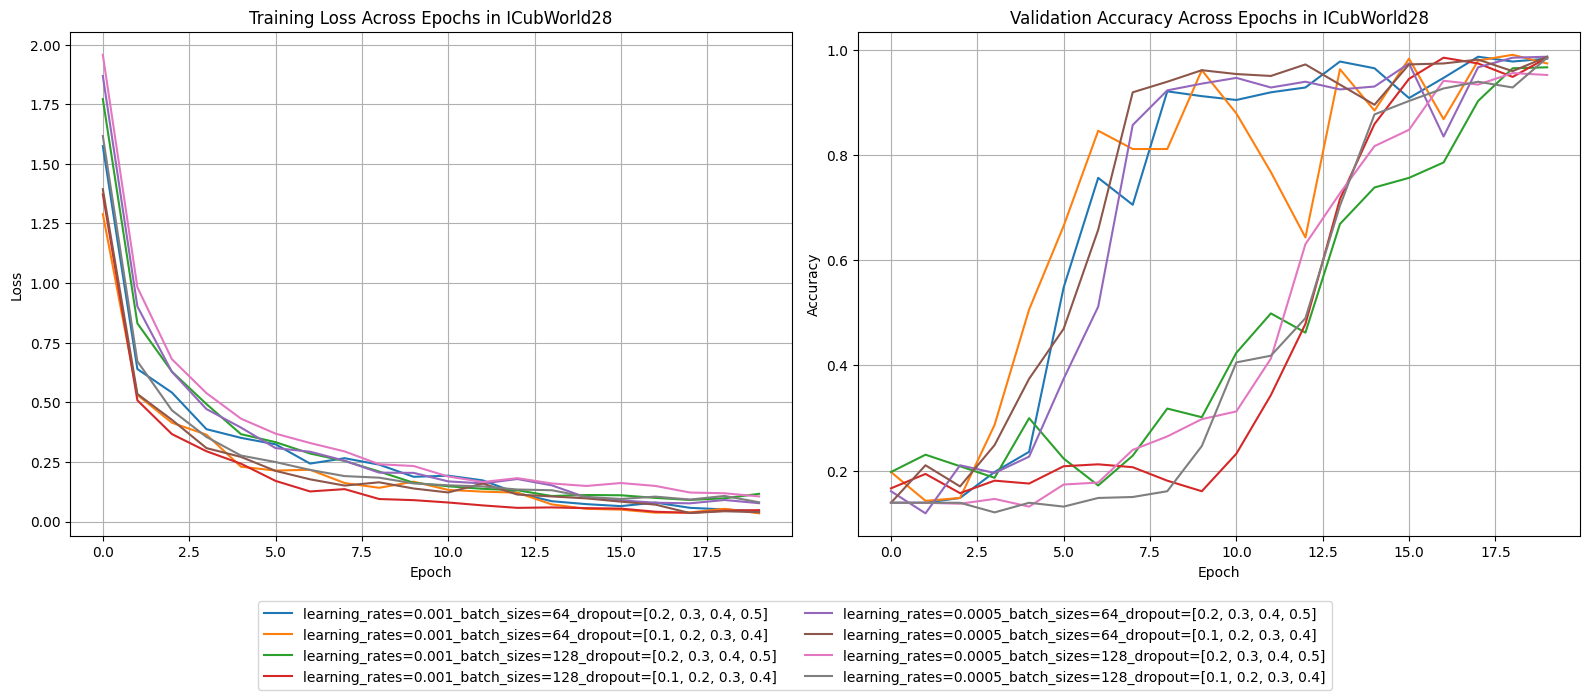

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create a list to hold the legend handles and labels
handles, labels = [], []

# Left plot: Training Loss
for name, hist in all_histories.items():
    line, = axes[0].plot(hist.history['loss'], label=name)
    handles.append(line)  # Save the line handle
    labels.append(name)   # Save the label for the legend
axes[0].set_title('Training Loss Across Epochs in ICubWorld28')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

# Right plot: Validation Accuracy
for name, hist in all_histories.items():
    axes[1].plot(hist.history['val_accuracy'], label=name)
axes[1].set_title('Validation Accuracy Across Epochs in ICubWorld28')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)

# Now add a single legend for both subplots
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0))

# Apply tight_layout for the whole figure
fig.tight_layout()

plt.show()



----------- Basic Evaluation -----------
Test Accuracy: 0.9791
Test Loss: 0.0784

---------- Aggregate Metrics -----------
Macro F1:       0.9791
Macro Precision:0.9791
Macro Recall:   0.9791
Weighted F1:       0.9791
Weighted Precision:0.9791
Weighted Recall:   0.9791

-------- Classification Report ---------
                       precision    recall  f1-score   support

                  cup     0.9846    0.9625    0.9734       799
dishwashing-detergent     0.9815    0.9925    0.9869       800
    laundry-detergent     0.9822    0.9835    0.9829       787
                plate     0.9712    0.9786    0.9749       793
                 soap     0.9962    0.9911    0.9936       787
               sponge     0.9717    0.9937    0.9826       796
              sprayer     0.9665    0.9518    0.9591       788

             accuracy                         0.9791      5550
            macro avg     0.9791    0.9791    0.9791      5550
         weighted avg     0.9791    0.9791    0.9791   

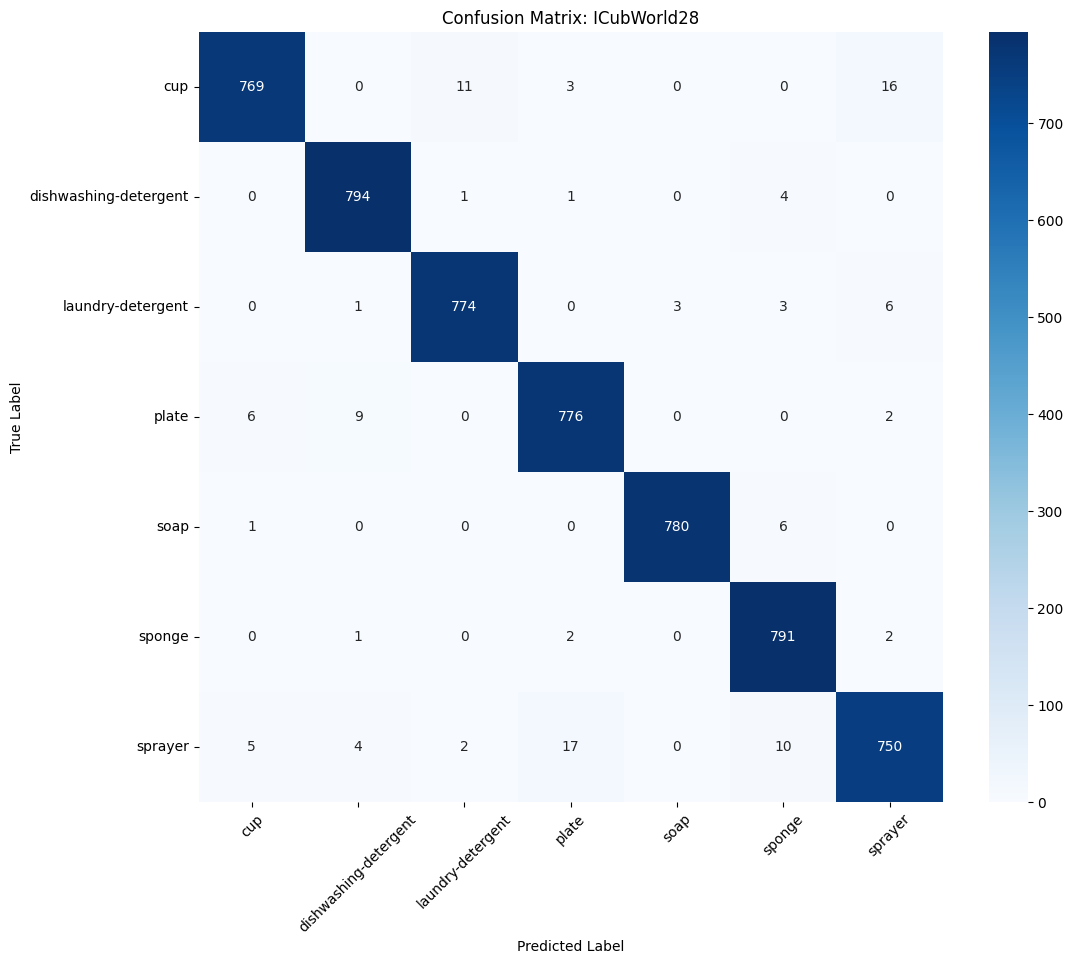

In [82]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

import seaborn as sns
from tensorflow.keras.models import load_model


# ====================================================
#               Enhanced Model Evaluation
# ====================================================
def enhanced_model_evaluation(model, X_test, y_test, class_names):
    # 基础评估
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f'\n{" Basic Evaluation ":-^40}')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Loss: {test_loss:.4f}')
    
    
    # 获取预测结果
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    

    # 各指标计算
    #宏平均差：先分别计算每个类别的指标值（如 F1、Precision、Recall），然后对这些值求平均。
    weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted')
    macro_f1 = f1_score(y_test, y_pred_classes, average='macro')
    
    weighted_precision = precision_score(y_test, y_pred_classes, average='weighted')
    macro_precision = precision_score(y_test, y_pred_classes, average='macro')
    
    weighted_recall = recall_score(y_test, y_pred_classes, average='weighted')
    macro_recall = recall_score(y_test, y_pred_classes, average='macro')

    print(f'\n{" Aggregate Metrics ":-^40}')
    print(f'Macro F1:       {macro_f1:.4f}')
    print(f'Macro Precision:{macro_precision:.4f}')
    print(f'Macro Recall:   {macro_recall:.4f}')
    
    print(f'Weighted F1:       {weighted_f1:.4f}')
    print(f'Weighted Precision:{weighted_precision:.4f}')
    print(f'Weighted Recall:   {weighted_recall:.4f}')
    
    
    # 多分类评估指标
    print(f'\n{" Classification Report ":-^40}')
    print(classification_report(y_test, y_pred_classes, target_names=class_names, digits=4))

    # 混淆矩阵可视化
    cm = confusion_matrix(y_test, y_pred_classes)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix: ICubWorld28')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    

# 执行增强评估
model = load_model("best_icub_cnn_model_0507.h5")
enhanced_model_evaluation(model, X_test, y_test, class_names)

In [11]:
def draw_bounding_box(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY_INV)  # 可以尝试其他阈值策略
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # 取最大轮廓作为物体（你也可以遍历所有轮廓）
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        image_with_box = image.copy()
        cv2.rectangle(image_with_box, (x, y), (x+w, y+h), (0,255,0), 2)
        return image_with_box, (x, y, w, h)
    else:
        return image, None

In [78]:
def predict_four_grid(image_paths, model, class_names):
    """
    Show up to 4 images in a 2×2 grid; in each cell: [original | bar-chart].
    
    - Histogram (bar) labels drawn inside each bar.
    - Columns brought closer together.
    """
    paths = image_paths[:4]
    n = len(paths)
    if n == 0:
        print("No images provided.")
        return []

    # Outer 2×2 grid, tighten wspace
    fig = plt.figure(figsize=(16, 8))
    outer = fig.add_gridspec(2, 2, wspace=0.1, hspace=0.3)

    results = []
    for idx, img_path in enumerate(paths):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Unable to read: {img_path}")
            continue

        # predict
        proc = cv2.resize(img, (32, 32))
        proc = cv2.cvtColor(proc, cv2.COLOR_BGR2RGB).astype('float32') / 255.0
        proc = np.expand_dims(proc, axis=0)
        pred = model.predict(proc)[0]
        i_max = np.argmax(pred)
        conf  = np.max(pred)
        results.append((class_names[i_max], conf))

        row, col = divmod(idx, 2)
        # nest a 1×2 inside each outer cell, tighten its wspace too
        inner = outer[row, col].subgridspec(1, 2, wspace=0)

        # original
        ax_img = fig.add_subplot(inner[0])
        ax_img.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax_img.set_title(f"Img {idx+1}")
        ax_img.axis('off')

        # bar chart
        ax_bar = fig.add_subplot(inner[1])
        bars = ax_bar.barh(class_names, pred,
                           color=['red' if i==i_max else 'skyblue'
                                  for i in range(len(class_names))])
        ax_bar.set_title(f"{class_names[i_max]}\n({conf:.1%})", pad=6)
        ax_bar.set_xlabel("Conf.")
        ax_bar.invert_yaxis()
        ax_bar.tick_params(axis='y', labelsize=8)

        # put the confidence % labels inside each bar
        ax_bar.bar_label(
            bars,
            labels=[f"{v:.1%}" for v in pred],
            label_type='edge',
            padding=2,
            fontsize=8,
        )

    plt.tight_layout()
    plt.show()
    return results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/rw/nvhbd9497sq4mxjs1jnndqy40000gn/T/ipykernel_90234/1300425733.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


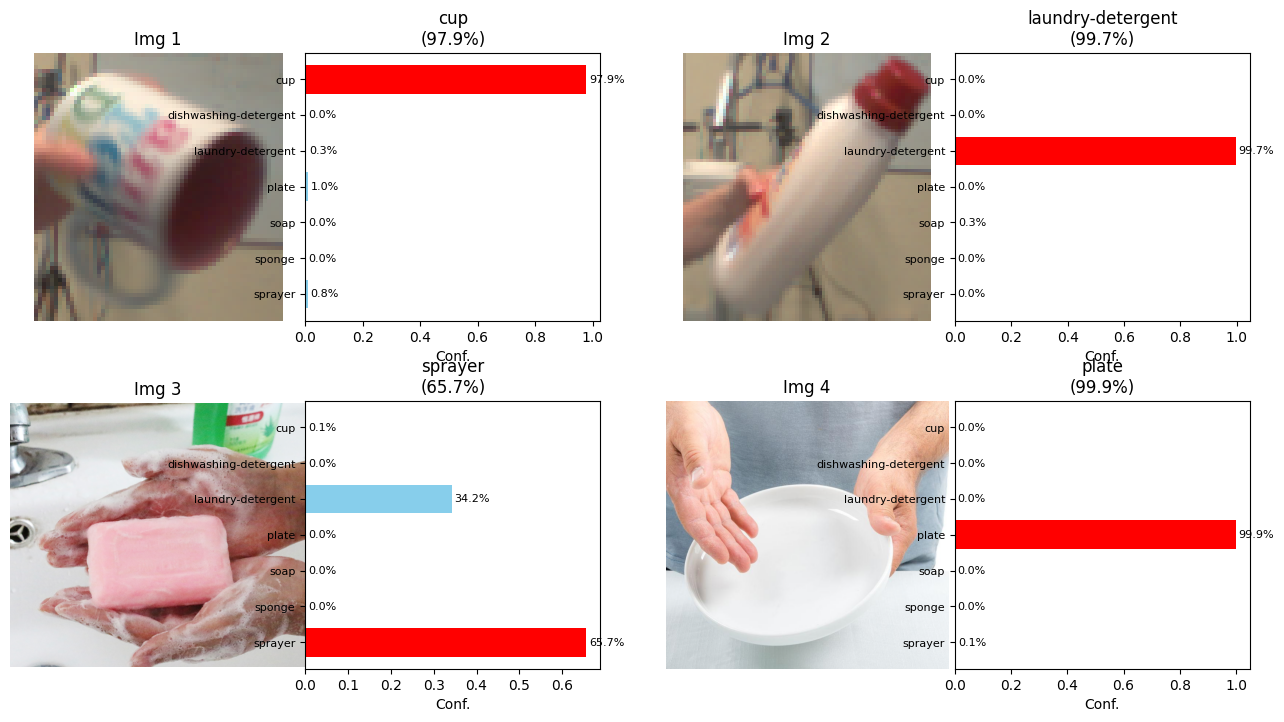

Image 1: cup (97.87%)
Image 2: laundry-detergent (99.70%)
Image 3: sprayer (65.66%)
Image 4: plate (99.92%)


In [81]:
# === Usage ===
class_names = ['cup','dishwashing-detergent','laundry-detergent',
               'plate','soap','sponge','sprayer']

paths = [
    "dataset/testImg/icub-1.ppm",
    "dataset/testImg/icub-2.ppm",
    "dataset/testImg/icub-3.png",
    "dataset/testImg/icub-4.png",
]

res = predict_four_grid(paths, model, class_names)
for i, (label, conf) in enumerate(res):
    print(f"Image {i+1}: {label} ({conf:.2%})")
